In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
# Configure Matplotlib to use LaTeX for text rendering
plt.rcParams['text.usetex'] = True

# Set fonts for Matplotlib
plt.rcParams['font.serif'] = 'Palatino'
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams['font.monospace'] = 'Courier'
plt.rcParams['font.size'] = 11
width_cm = 15
height_cm = 6
# Convert centimeters to inches
width_in = width_cm / 2.54
height_in = height_cm / 2.54
import seaborn as sns
sns.set_theme()
figsize= (width_in, height_in)


import numpy as np
import pandas as pd 
import wandb
from metrics.plotting_utils import save_plot, get_history_from_project, save_csv, get_dataset_name_mapping
from ood_detection.config import Config
from datasets.config import DATASETS_DICT



dataset_mapping = get_dataset_name_mapping()
api = wandb.Api()

/home/fmeyer/miniconda3/envs/ood/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
/home/fmeyer/miniconda3/envs/ood/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Classification improvements:
1. Compare zeroshot baseline to TIP & TIP-f. Maybe add linear


In [2]:
orig = get_history_from_project('thesis-tip-adapters-16_shots-temp_0.01', set_name_index=False)

In [3]:
zsa, tip, tipf = 'ZEROSHOT', 'TIP ADAPTER', 'TIP-F ADAPTER'
diffs = [f"{zsa}-{tip}", f"{zsa}-{tipf}", f"{tip}-{tipf}"]
metrics = [zsa, tip, tipf]
metric_converter = {'ZEROSHOT': 'ZSA', 'TIP ADAPTER':'TIP', 'TIP-F ADAPTER':'TIP-f' }

In [4]:
classification_df = orig.copy()
classification_df = classification_df.sort_values('name').reset_index(drop=True)
classification_df['name']= classification_df['name'].apply(lambda x: dataset_mapping[x])
means = classification_df

### get differences

In [5]:
for met1 in metrics:
    for met2 in metrics:
        if met1 == met2:
            continue
        classification_df[f'{met1}-{met2}'] = classification_df.apply(lambda row: row[met2] - row[met1],  axis=1)

## Means & stds overall

In [6]:
classification_df[metrics].mean().round(2)

ZEROSHOT         57.35
TIP ADAPTER      66.92
TIP-F ADAPTER    66.73
dtype: float64

In [7]:
classification_df[metrics].std()

ZEROSHOT         18.040034
TIP ADAPTER      17.959662
TIP-F ADAPTER    14.894692
dtype: float64

In [8]:
classification_df[diffs].mean()

ZEROSHOT-TIP ADAPTER         9.572160
ZEROSHOT-TIP-F ADAPTER       9.379388
TIP ADAPTER-TIP-F ADAPTER   -0.192772
dtype: float64

In [9]:
#classification_df[diffs].std()

In [10]:
#for name, group in classification_df.groupby('name'):
    #print(name)
    #print('mean')
    #print(group[metrics].mean())
   # print('std')
    #print(group[metrics].std())
    #print('\n')

In [11]:
#classification_df[diffs].std()

In [12]:
#for name, group in classification_df.groupby('name'):
#    print(name)
#    print('\t\tmean')
#    print(group[metrics].mean())
#    print('\t\tSTD')
#    print(group[metrics].std())
#    print('\n')

### Plot errorbars over all datasets for appendix

In [13]:
def plot_errorbar(means, stds, metric):
    
    error_corr = .5 * stds[metric]
    lower = means[metric] - error_corr
    upper = means[metric] + error_corr
    ax.plot(means.index, means[metric], label= metric_converter[metric])
    ax.plot(lower, color='tab:blue', alpha=.1)
    ax.plot(upper, color='tab:blue', alpha=.1)
    ax.fill_between(range(len(means)), lower, upper, alpha=.3)

In [14]:
classification_df.sort_values('name')

,TIP-F F1,ZEROSHOT,TIP ADAPTER,temperature,TIP F1,TIP-F ADAPTER,tip_best_beta,shots_per_class,zf1,tipf_best_beta,tipf_best_alpha,tip_best_alpha,name,ZEROSHOT-TIP ADAPTER,ZEROSHOT-TIP-F ADAPTER,TIP ADAPTER-ZEROSHOT,TIP ADAPTER-TIP-F ADAPTER,TIP-F ADAPTER-ZEROSHOT,TIP-F ADAPTER-TIP ADAPTER
26,90.487825,89.83,91.47,0.01,91.476220,90.51,5.000000,16,89.813228,0.644444,1.188889,1.733333,CIFAR10,1.64,0.68,-1.64,-0.96,-0.68,0.96
22,90.556678,89.83,91.15,0.01,91.142415,90.55,5.000000,16,89.813228,3.366667,5.000000,1.733333,CIFAR10,1.32,0.72,-1.32,-0.60,-0.72,0.60
23,91.006955,89.83,91.40,0.01,91.393785,91.02,3.911111,16,89.813228,3.366667,4.455556,1.733333,CIFAR10,1.57,1.19,-1.57,-0.38,-1.19,0.38
24,90.703967,89.83,91.48,0.01,91.486103,90.69,5.000000,16,89.813228,1.733333,1.733333,1.733333,CIFAR10,1.65,0.86,-1.65,-0.79,-0.86,0.79
25,90.767335,89.83,91.64,0.01,91.649047,90.78,3.366667,16,89.813228,2.822222,3.366667,1.733333,CIFAR10,1.81,0.95,-1.81,-0.86,-0.95,0.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,67.336007,62.88,66.08,0.01,65.543786,67.49,5.000000,16,62.419706,1.733333,1.733333,1.733333,TinyImagenet,3.20,4.61,-3.20,1.41,-4.61,-1.41
86,67.050028,62.88,65.62,0.01,65.168054,67.39,4.455556,16,62.419706,1.188889,1.188889,1.733333,TinyImagenet,2.74,4.51,-2.74,1.77,-4.51,-1.77
89,67.475863,62.88,65.89,0.01,65.315672,67.61,5.000000,16,62.419706,2.822222,2.822222,1.733333,TinyImagenet,3.01,4.73,-3.01,1.72,-4.73,-1.72
83,67.367291,62.88,65.77,0.01,65.304953,67.70,5.000000,16,62.419706,2.277778,1.733333,1.733333,TinyImagenet,2.89,4.82,-2.89,1.93,-4.82,-1.93


In [15]:
 classification_df['name'].unique()

array(['Caltech CUB', 'Caltech101', 'CIFAR10', 'CIFAR100', 'DTD',
       'Fashion MNIST', 'Flowers102', 'GTSRB', 'TinyImagenet', 'MNIST',
       'Stanford Cars', 'SVHN'], dtype=object)

In [16]:
for met in diffs[:2]:
    classification_df[met+'-percent'] = classification_df[met] /classification_df['ZEROSHOT']

In [17]:
classification_df.columns

Index(['TIP-F F1', 'ZEROSHOT', 'TIP ADAPTER', 'temperature', 'TIP F1',
       'TIP-F ADAPTER', 'tip_best_beta', 'shots_per_class', 'zf1',
       'tipf_best_beta', 'tipf_best_alpha', 'tip_best_alpha', 'name',
       'ZEROSHOT-TIP ADAPTER', 'ZEROSHOT-TIP-F ADAPTER',
       'TIP ADAPTER-ZEROSHOT', 'TIP ADAPTER-TIP-F ADAPTER',
       'TIP-F ADAPTER-ZEROSHOT', 'TIP-F ADAPTER-TIP ADAPTER',
       'ZEROSHOT-TIP ADAPTER-percent', 'ZEROSHOT-TIP-F ADAPTER-percent'],
      dtype='object')

In [18]:
percents = ['ZEROSHOT-TIP ADAPTER-percent', 'ZEROSHOT-TIP-F ADAPTER-percent']

In [19]:
means = classification_df[metrics + ['name']].groupby('name').mean()
stds = classification_df[metrics + ['name']].groupby('name').std()

mean_std = pd.concat([means, stds.rename(columns={'ZEROSHOT':'z-std', 'TIP ADAPTER': 'TIP-std', 'TIP-F ADAPTER':'TIP-F-std'})], axis=1).round(2)
mean_std['ZEROSHOT'] = mean_std['ZEROSHOT'].astype(str) + " \pm "+  mean_std['z-std'].astype(str)
mean_std['TIP ADAPTER'] = mean_std['TIP ADAPTER'].astype(str) + " \pm "+  mean_std['TIP-std'].astype(str)
mean_std['TIP-F ADAPTER'] = mean_std['TIP-F ADAPTER'].astype(str) + " \pm "+  mean_std['TIP-F-std'].astype(str)
save_csv(mean_std[metrics], '6', 'classification_adapter_plusminus')

In [20]:
means

,ZEROSHOT,TIP ADAPTER,TIP-F ADAPTER
name,,,
CIFAR10,89.830000,91.367000,90.720000
CIFAR100,64.230000,67.483000,69.061000
Caltech CUB,52.140145,61.836382,59.597860
Caltech101,83.722270,89.037741,89.403630
DTD,44.414894,59.106383,61.218085
Fashion MNIST,59.560000,73.229000,70.502000
Flowers102,66.287201,86.609205,75.574890
GTSRB,32.319873,44.920823,51.198733
MNIST,48.220000,69.657000,64.170000


In [21]:
mean_std

,ZEROSHOT,TIP ADAPTER,TIP-F ADAPTER,z-std,TIP-std,TIP-F-std
name,,,,,,
CIFAR10,89.83 \pm 0.0,91.37 \pm 0.18,90.72 \pm 0.17,0.0,0.18,0.17
CIFAR100,64.23 \pm 0.0,67.48 \pm 0.31,69.06 \pm 0.11,0.0,0.31,0.11
Caltech CUB,52.14 \pm 0.0,61.84 \pm 0.36,59.6 \pm 0.13,0.0,0.36,0.13
Caltech101,83.72 \pm 0.0,89.04 \pm 0.5,89.4 \pm 0.31,0.0,0.50,0.31
DTD,44.41 \pm 0.0,59.11 \pm 1.04,61.22 \pm 0.66,0.0,1.04,0.66
Fashion MNIST,59.56 \pm 0.0,73.23 \pm 1.11,70.5 \pm 0.38,0.0,1.11,0.38
Flowers102,66.29 \pm 0.0,86.61 \pm 0.16,75.57 \pm 0.4,0.0,0.16,0.40
GTSRB,32.32 \pm 0.0,44.92 \pm 2.74,51.2 \pm 1.32,0.0,2.74,1.32
MNIST,48.22 \pm 0.0,69.66 \pm 3.58,64.17 \pm 2.17,0.0,3.58,2.17


In [22]:
classification_df.groupby('name').mean()[metrics + percents].abs().sort_values(percents[1])


,ZEROSHOT,TIP ADAPTER,TIP-F ADAPTER,ZEROSHOT-TIP ADAPTER-percent,ZEROSHOT-TIP-F ADAPTER-percent
name,,,,,
CIFAR10,89.830000,91.367000,90.720000,0.017110,0.009908
Caltech101,83.722270,89.037741,89.403630,0.063489,0.067860
TinyImagenet,62.880000,65.868000,67.481000,0.047519,0.073171
CIFAR100,64.230000,67.483000,69.061000,0.050646,0.075214
Flowers102,66.287201,86.609205,75.574890,0.306575,0.140113
Caltech CUB,52.140145,61.836382,59.597860,0.185965,0.143032
Stanford Cars,59.656759,68.503917,68.450441,0.148301,0.147405
Fashion MNIST,59.560000,73.229000,70.502000,0.229500,0.183714
MNIST,48.220000,69.657000,64.170000,0.444567,0.330776


##### classification_df.groupby('name').mean()[metrics + diffs].sort_values(diffs[0], ascending=False)

In [23]:
classification_df.groupby('name').mean()[metrics + diffs].sort_values(diffs[2])

,ZEROSHOT,TIP ADAPTER,TIP-F ADAPTER,ZEROSHOT-TIP ADAPTER,ZEROSHOT-TIP-F ADAPTER,TIP ADAPTER-TIP-F ADAPTER
name,,,,,,
Flowers102,66.287201,86.609205,75.574890,20.322004,9.287689,-11.034315
MNIST,48.220000,69.657000,64.170000,21.437000,15.950000,-5.487000
Fashion MNIST,59.560000,73.229000,70.502000,13.669000,10.942000,-2.727000
Caltech CUB,52.140145,61.836382,59.597860,9.696237,7.457715,-2.238523
CIFAR10,89.830000,91.367000,90.720000,1.537000,0.890000,-0.647000
Stanford Cars,59.656759,68.503917,68.450441,8.847158,8.793682,-0.053476
Caltech101,83.722270,89.037741,89.403630,5.315471,5.681360,0.365889
CIFAR100,64.230000,67.483000,69.061000,3.253000,4.831000,1.578000
TinyImagenet,62.880000,65.868000,67.481000,2.988000,4.601000,1.613000


In [24]:
meaned_cl_df = classification_df.groupby('name').mean()[metrics + diffs].abs().sort_values(diffs[2],ascending=True)

In [25]:
means.sort_values(metrics[1])

,ZEROSHOT,TIP ADAPTER,TIP-F ADAPTER
name,,,
SVHN,24.946220,25.454825,33.382376
GTSRB,32.319873,44.920823,51.198733
DTD,44.414894,59.106383,61.218085
Caltech CUB,52.140145,61.836382,59.597860
TinyImagenet,62.880000,65.868000,67.481000
CIFAR100,64.230000,67.483000,69.061000
Stanford Cars,59.656759,68.503917,68.450441
MNIST,48.220000,69.657000,64.170000
Fashion MNIST,59.560000,73.229000,70.502000


In [26]:
stds

,ZEROSHOT,TIP ADAPTER,TIP-F ADAPTER
name,,,
CIFAR10,0.0,0.178515,0.166199
CIFAR100,0.0,0.310771,0.107025
Caltech CUB,0.0,0.357506,0.125636
Caltech101,0.0,0.499237,0.313782
DTD,0.0,1.038044,0.655525
Fashion MNIST,0.0,1.114086,0.378823
Flowers102,0.0,0.162121,0.396096
GTSRB,0.0,2.744978,1.324915
MNIST,0.0,3.582994,2.172172


In [27]:
metrics = ['ZEROSHOT', 'TIP ADAPTER', 'TIP-F ADAPTER']
metrics_and_name = metrics + ['name']
std_metrics = [metric + '_std' for metric in metrics]
tip_mappings = {'tip':'T-MCM', 'tipf':'T-MCM-f', 'clip':'MCM'}

/tmp/ipykernel_884/1239665986.py:9: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.vlines([range(len(means))], ymin=0, ymax=means.max(axis=1),color='darkgrey', alpha=0.6)
/tmp/ipykernel_884/1239665986.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels([ind for ind in classification_df['name'].unique()], rotation=45, ha='right')


Tikzplotlib failed could not convert string to float: 'CIFAR10'
Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/svg/6
Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/6


True

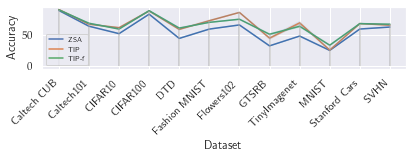

In [28]:
fig, ax = plt.subplots(figsize=figsize)

means = classification_df[metrics_and_name].groupby('name').mean()
stds = classification_df[metrics_and_name].groupby('name').std()

plot_errorbar(means, stds, metrics[0])
plot_errorbar(means, stds, metrics[1])
plot_errorbar(means, stds, metrics[2])
ax.vlines([range(len(means))], ymin=0, ymax=means.max(axis=1),color='darkgrey', alpha=0.6)

_ =ax.legend(fontsize=7, loc='lower left')
_ = ax.set_xticklabels
_ = ax.set_xticklabels([ind for ind in classification_df['name'].unique()], rotation=45, ha='right')
ax.set_ylabel('Accuracy %')
ax.set_xlabel('Dataset')
plt.tight_layout()

save_plot(fig, 'accuracies_domain_adaption', '6', False)

In [29]:
classification_df[metrics_and_name].groupby('name').mean()

,ZEROSHOT,TIP ADAPTER,TIP-F ADAPTER
name,,,
CIFAR10,89.830000,91.367000,90.720000
CIFAR100,64.230000,67.483000,69.061000
Caltech CUB,52.140145,61.836382,59.597860
Caltech101,83.722270,89.037741,89.403630
DTD,44.414894,59.106383,61.218085
Fashion MNIST,59.560000,73.229000,70.502000
Flowers102,66.287201,86.609205,75.574890
GTSRB,32.319873,44.920823,51.198733
MNIST,48.220000,69.657000,64.170000


### MCM 

In [30]:
adapter_df = get_history_from_project('thesis-toc-ood-test-hyperparam-search-10-runs', False)
working_adapter = adapter_df.copy()
working_adapter['name'] =working_adapter['name'].apply(lambda x: dataset_mapping[x]) 

In [31]:
metrics_and_name

['ZEROSHOT', 'TIP ADAPTER', 'TIP-F ADAPTER', 'name']

In [32]:
metrics = ['tip', 'tipf', 'clip']
metrics_and_name = metrics + ['name']
std_metrics = [metric + '_std' for metric in metrics]
tip_mappings = {'tip':'T-MCM', 'tipf':'T-MCM-f', 'clip':'MCM'}

In [33]:
diff_bigger = 10
columns_of_relevance = 'ZEROSHOT-TIP ADAPTER'
# get the names were adaption is better than xy points
full_mean = classification_df.groupby('name').mean()
names = full_mean[full_mean[columns_of_relevance] > diff_bigger].index.values


In [34]:
to_safe = working_adapter[metrics+['name']+ std_metrics].set_index('name').round(3)
for metric, std_metric in zip(metrics, std_metrics):
    to_safe[metric] = to_safe[metric].astype(str) + " \pm "+  to_safe[std_metric].astype(str)
to_safe = to_safe.drop(std_metrics, axis=1).sort_index()


In [35]:
save_csv(to_safe.rename(columns=metric_converter).sort_index(), "6", "mcm_tip_tipf")

In [36]:
to_safe.rename(columns=metric_converter)

,tip,tipf,clip
name,,,
CIFAR10,0.881 \pm 0.026,0.907 \pm 0.013,0.9 \pm 0.019
CIFAR100,0.717 \pm 0.024,0.77 \pm 0.017,0.735 \pm 0.025
Caltech CUB,0.665 \pm 0.014,0.643 \pm 0.022,0.639 \pm 0.014
Caltech101,0.897 \pm 0.035,0.897 \pm 0.036,0.87 \pm 0.05
DTD,0.731 \pm 0.024,0.71 \pm 0.027,0.664 \pm 0.045
Fashion MNIST,0.73 \pm 0.043,0.706 \pm 0.084,0.701 \pm 0.08
Flowers102,0.856 \pm 0.023,0.775 \pm 0.032,0.773 \pm 0.028
GTSRB,0.578 \pm 0.061,0.549 \pm 0.062,0.515 \pm 0.062
MNIST,0.661 \pm 0.095,0.622 \pm 0.055,0.591 \pm 0.086


In [37]:
working_adapter[metrics].mean().round(3)

tip     0.722
tipf    0.713
clip    0.693
dtype: float64

In [38]:
working_adapter[std_metrics].mean().round(3)

tip_std     0.035
tipf_std    0.035
clip_std    0.041
dtype: float64

## Use only good adapted ones

In [39]:
diff_bigger = 10
columns_of_relevance = 'ZEROSHOT-TIP-F ADAPTER'
# get the names were adaption is better than xy points
full_mean = classification_df.groupby('name').mean()
names = full_mean[full_mean[columns_of_relevance] > diff_bigger].index.values
print(f"Acc improvement over {diff_bigger}: {names}")

Acc improvement over 10: ['DTD' 'Fashion MNIST' 'GTSRB' 'MNIST']


In [40]:
working_adapter.set_index('name').loc[names][metrics].mean().round(3)

tip     0.675
tipf    0.647
clip    0.618
dtype: float64

In [41]:
working_adapter.set_index('name').loc[names][metrics].mean().round(3)

tip     0.675
tipf    0.647
clip    0.618
dtype: float64

In [42]:
diff_bigger = 10
columns_of_relevance = 'ZEROSHOT-TIP ADAPTER'
# get the names were adaption is better than xy points
full_mean = classification_df.groupby('name').mean()
names = full_mean[full_mean[columns_of_relevance] > diff_bigger].index.values
print(f"Acc improvement over {diff_bigger}: {names}")

Acc improvement over 10: ['DTD' 'Fashion MNIST' 'Flowers102' 'GTSRB' 'MNIST']


In [43]:
working_adapter.set_index('name').loc[names][metrics].mean().round(3)

tip     0.711
tipf    0.672
clip    0.649
dtype: float64

In [44]:
working_adapter.set_index('name').loc[names][std_metrics].mean().round(3)

tip_std     0.049
tipf_std    0.052
clip_std    0.060
dtype: float64

<AxesSubplot:>

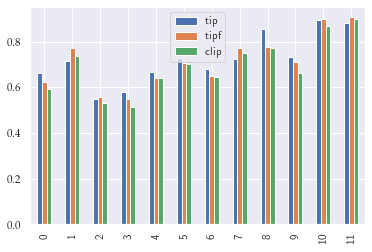

In [45]:
working_adapter[metrics].plot(kind='bar')

## ZOC

In [46]:
working_adapter = adapter_df.copy()
working_adapter['name'] = working_adapter['name'].apply(lambda x: dataset_mapping[x])
working_adapter.set_index('name', inplace=True)
metrics_z = ['zoc', 'toc', 'tocf']
std_metrics_z = [metric + '_std' for metric in metrics_z]
tip_mappings = {'zoc':'ZOC', 'toc':'T-ZOC', 'toc-f':'T-ZOC-f'}
working_adapter[metrics_z].mean().round(3)

zoc     0.727
toc     0.737
tocf    0.733
dtype: float64

In [47]:
working_adapter[std_metrics_z].mean().round(3)

zoc_std     0.044
toc_std     0.031
tocf_std    0.042
dtype: float64

In [48]:
names

array(['DTD', 'Fashion MNIST', 'Flowers102', 'GTSRB', 'MNIST'],
      dtype=object)

In [49]:
working_adapter.loc[names][metrics_z].mean().round(3)

zoc     0.675
toc     0.719
tocf    0.681
dtype: float64

In [50]:
working_adapter.loc[names][std_metrics_z].mean().round(3)

zoc_std     0.071
toc_std     0.038
tocf_std    0.069
dtype: float64

In [51]:
renamer_for_plot = {'zoc':'ZOC', 'toc':'T-ZOC', 'tip':'T-MCM', 'tocf':'T-ZOC-f', 'tipf':'T-MCM-f', 'clip':'MCM'}

In [52]:
barplot_df =  working_adapter.rename(columns=renamer_for_plot).loc[names][['MCM', 'T-MCM', 'T-ZOC']]

In [53]:
barplot_df

,MCM,T-MCM,T-ZOC
name,,,
DTD,0.664373,0.730630,0.711862
Fashion MNIST,0.700814,0.730275,0.798209
Flowers102,0.772584,0.856279,0.891453
GTSRB,0.514777,0.577612,0.614035
MNIST,0.591086,0.660915,0.577198


In [54]:
figsize

(5.905511811023622, 2.3622047244094486)

/home/fmeyer/miniconda3/envs/ood/lib/python3.8/site-packages/tikzplotlib/_cleanfigure.py:200: UserWarning: Cleaning Bar Container (bar plot) is not supported yet.
  warnings.warn("Cleaning Bar Container (bar plot) is not supported yet.")
/home/fmeyer/miniconda3/envs/ood/lib/python3.8/site-packages/tikzplotlib/_cleanfigure.py:166: UserWarning: Cleaning Line Collections (scatter plot) is not supported yet.
  warnings.warn(


Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/tickz/6
Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/svg/6
Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/6


True

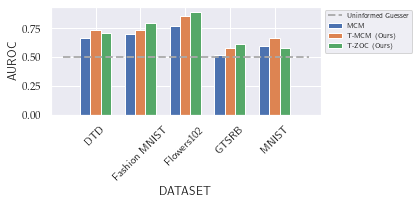

In [55]:
fig, ax = plt.subplots(figsize=(figsize[0], 3))
bar_width = 0.23
pos1 = range(len(barplot_df))
pos2 = [bar_width+pos for pos in pos1]
pos3 = [bar_width+pos for pos in pos2]

ax.bar(pos1, barplot_df['MCM'], width=bar_width, label='MCM')
ax.bar(pos2, barplot_df['T-MCM'], width=bar_width, label='T-MCM (Ours)')
ax.bar(pos3, barplot_df['T-ZOC'], width=bar_width, label='T-ZOC (Ours)')
ax.hlines(0.5, xmin=-.5, xmax=[len(barplot_df)], colors='darkgrey', alpha=0.9, linestyles='--', lw=2, label='Uninformed Guesser')
_ = ax.set_xticks(pos2)
ax.set_xticklabels(barplot_df.index, rotation=45)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=7)
ax.set_ylabel('AUROC')
ax.set_xlabel('DATASET')
plt.tight_layout()

save_plot(fig, 'best_bars','6', False)

# corrs

In [56]:
classification_df.groupby('name').mean().columns

Index(['TIP-F F1', 'ZEROSHOT', 'TIP ADAPTER', 'temperature', 'TIP F1',
       'TIP-F ADAPTER', 'tip_best_beta', 'shots_per_class', 'zf1',
       'tipf_best_beta', 'tipf_best_alpha', 'tip_best_alpha',
       'ZEROSHOT-TIP ADAPTER', 'ZEROSHOT-TIP-F ADAPTER',
       'TIP ADAPTER-ZEROSHOT', 'TIP ADAPTER-TIP-F ADAPTER',
       'TIP-F ADAPTER-ZEROSHOT', 'TIP-F ADAPTER-TIP ADAPTER',
       'ZEROSHOT-TIP ADAPTER-percent', 'ZEROSHOT-TIP-F ADAPTER-percent'],
      dtype='object')

In [57]:
class_and_ood = pd.concat([classification_df.groupby('name').mean()[['ZEROSHOT', 'TIP ADAPTER', 'TIP-F ADAPTER', 'ZEROSHOT-TIP ADAPTER','ZEROSHOT-TIP-F ADAPTER']], working_adapter.rename(columns=renamer_for_plot).drop([col for col in working_adapter.columns if "_std" in col],axis=1)], axis=1)

In [58]:
auroc_metrics = ['T-ZOC-f', 'T-ZOC', 'MCM', 'T-MCM', 'T-MCM-f','ZOC']

In [59]:
class_and_ood.corr()[auroc_metrics]

,T-ZOC-f,T-ZOC,MCM,T-MCM,T-MCM-f,ZOC
ZEROSHOT,0.979159,0.900207,0.959411,0.916204,0.938533,0.971924
TIP ADAPTER,0.887156,0.890806,0.861464,0.921450,0.837851,0.887761
TIP-F ADAPTER,0.929498,0.904531,0.911704,0.930883,0.900447,0.916006
ZEROSHOT-TIP ADAPTER,-0.259782,-0.042074,-0.274952,-0.004052,-0.281706,-0.239123
ZEROSHOT-TIP-F ADAPTER,-0.734651,-0.533212,-0.717121,-0.513443,-0.677097,-0.748065
T-ZOC-f,1.000000,0.940101,0.973241,0.922105,0.946250,0.994900
T-ZOC,0.940101,1.000000,0.903765,0.939091,0.869303,0.936885
MCM,0.973241,0.903765,1.000000,0.952665,0.992407,0.959159
T-MCM,0.922105,0.939091,0.952665,1.000000,0.944720,0.909419
T-MCM-f,0.946250,0.869303,0.992407,0.944720,1.000000,0.921980


In [60]:
classification_df.groupby('name').mean()[['ZEROSHOT-TIP ADAPTER', 'ZEROSHOT-TIP-F ADAPTER',
       'TIP ADAPTER-ZEROSHOT', 'TIP ADAPTER-TIP-F ADAPTER',
       'TIP-F ADAPTER-ZEROSHOT']].round(2)

,ZEROSHOT-TIP ADAPTER,ZEROSHOT-TIP-F ADAPTER,TIP ADAPTER-ZEROSHOT,TIP ADAPTER-TIP-F ADAPTER,TIP-F ADAPTER-ZEROSHOT
name,,,,,
CIFAR10,1.54,0.89,-1.54,-0.65,-0.89
CIFAR100,3.25,4.83,-3.25,1.58,-4.83
Caltech CUB,9.70,7.46,-9.70,-2.24,-7.46
Caltech101,5.32,5.68,-5.32,0.37,-5.68
DTD,14.69,16.80,-14.69,2.11,-16.80
Fashion MNIST,13.67,10.94,-13.67,-2.73,-10.94
Flowers102,20.32,9.29,-20.32,-11.03,-9.29
GTSRB,12.60,18.88,-12.60,6.28,-18.88
MNIST,21.44,15.95,-21.44,-5.49,-15.95


## Benchmark comp

In [61]:
bench = get_history_from_project('thesis-ood-benchmark-logistic', False)


In [62]:
bench_df = bench.copy()
bench_df['name'] = bench_df['name'].apply(lambda x: dataset_mapping[x])

In [63]:
bench_df = bench_df.set_index('name')
bench_df = bench_df.rename(columns={'AUC': 'Benchmark'})

In [64]:
final_full = pd.concat([working_adapter.rename(columns=renamer_for_plot)[['MCM', 'T-MCM','T-MCM-f', 'ZOC', 'T-ZOC', 'T-ZOC-f']], bench_df.drop('std', axis=1)], axis=1)

In [65]:
save_csv(final_full.round(3), folder='6', name='full_oodd_with_benchmark')

In [66]:
final = pd.concat([working_adapter.rename(columns=renamer_for_plot)[['MCM', 'T-MCM', 'T-ZOC']], bench_df.drop('std', axis=1)], axis=1)

In [67]:
final.mean()

MCM          0.693001
T-MCM        0.722116
T-ZOC        0.736540
Benchmark    0.822071
dtype: float64

In [68]:
final.loc[names]['T-MCM'] - final.loc[names]['T-MCM']

name
DTD              0.0
Fashion MNIST    0.0
Flowers102       0.0
GTSRB            0.0
MNIST            0.0
Name: T-MCM, dtype: float64

/home/fmeyer/miniconda3/envs/ood/lib/python3.8/site-packages/tikzplotlib/_cleanfigure.py:200: UserWarning: Cleaning Bar Container (bar plot) is not supported yet.
  warnings.warn("Cleaning Bar Container (bar plot) is not supported yet.")
/home/fmeyer/miniconda3/envs/ood/lib/python3.8/site-packages/tikzplotlib/_cleanfigure.py:166: UserWarning: Cleaning Line Collections (scatter plot) is not supported yet.
  warnings.warn(


Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/tickz/6
Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/svg/6
Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/6


True

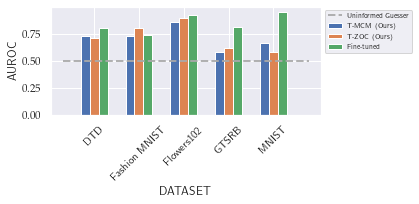

In [69]:
fig, ax = plt.subplots(figsize=(figsize[0], 3))
bar_width = 0.2
pos1 = range(len(final.loc[names]))
pos2 = [bar_width+pos for pos in pos1]
pos3 = [bar_width+pos for pos in pos2]

ax.bar(pos1, final.loc[names]['T-MCM'], width=bar_width, label='T-MCM (Ours)')
ax.bar(pos2, final.loc[names]['T-ZOC'], width=bar_width, label='T-ZOC (Ours)')
ax.bar(pos3, final.loc[names]['Benchmark'], width=bar_width, label='Fine-tuned')

ax.hlines(0.5, xmin=-.5, xmax=[len(final.loc[names])], colors='darkgrey', alpha=0.9, linestyles='--', lw=2, label='Uninformed Guesser')
_ = ax.set_xticks(pos2)
ax.set_xticklabels(final.loc[names].index, rotation=45)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=7)
ax.set_ylabel('AUROC')
ax.set_xlabel('DATASET')
plt.tight_layout()
save_plot(fig, 'benchmark bars','6', False)

In [70]:
final.mean()

MCM          0.693001
T-MCM        0.722116
T-ZOC        0.736540
Benchmark    0.822071
dtype: float64

## All classification resultos

In [71]:
bench_class_df = get_history_from_project('thesis-classification-logistic_head-large', False)
base_class_df = get_history_from_project('thesis-classification-logistic', False) 

In [72]:
bench_class = bench_class_df.copy()
bench_class['name'] = bench_class['name'].apply(lambda x: dataset_mapping[x])
bench_class = bench_class.set_index('name')
bench_class = bench_class.rename(columns={'test accuracy': 'Logistic - ViT-L/16@336px'})

In [73]:
base_class = base_class_df.copy()
base_class['name'] = base_class['name'].apply(lambda x: dataset_mapping[x])
base_class = base_class.set_index('name')
base_class = base_class.rename(columns={'Acc': 'Logistic - ViT-B/32'})

In [74]:
bench_class

,Logistic - ViT-L/16@336px
name,
SVHN,0.779771
Stanford Cars,0.896903
MNIST,0.989900
TinyImagenet,0.844200
GTSRB,0.928979
Flowers102,0.985201
Fashion MNIST,0.910000
DTD,0.792021
CIFAR100,0.860900


In [75]:
class_metrics = ['TIP ADAPTER', 'TIP-F ADAPTER', 'ZEROSHOT']

In [76]:
full_reg = pd.concat([base_class*100, bench_class*100, classification_df.groupby('name').mean()[class_metrics]], axis=1)

In [77]:
full_reg.sort_index(inplace=True)

/tmp/ipykernel_884/2450261756.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(full_reg.index, rotation=45, ha='right')


Tikzplotlib failed could not convert string to float: 'CIFAR10'
Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/svg/6
Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/6


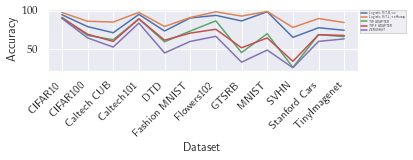

In [78]:
fig, ax = plt.subplots(figsize=figsize)
for col in full_reg.columns:
    ax.plot(full_reg.index, full_reg[col], label=col)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=3)
ax.set_xticklabels(full_reg.index, rotation=45, ha='right')

ax.set_ylabel('Accuracy %')
ax.set_xlabel('Dataset')
plt.tight_layout()

save_plot(fig, 'full_classification_line','6', False)
save_csv(full_reg.round(3),folder='6', name="full classification results")